In [1]:
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats
from scipy.stats import norm
%matplotlib inline

### 1. Load in the summarized subject data

A total of 72 subjects


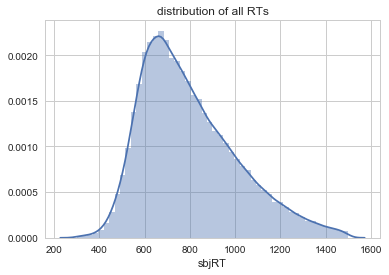

In [3]:
df = pd.read_pickle('v2\gpData_v2.pkl')
NrSbj = len(df.sbjId.unique())
#sns.distplot(df.loc[~np.isnan(df.sbjRT),'sbjRT'])
print('A total of ' + str(NrSbj) + ' subjects')
df.loc[df.sbjRT<300, 'sbjRT']  = np.nan
df.loc[df.sbjRT<300, 'sbjACC'] = 0
df.loc[df.sbjRT>1500, 'sbjRT']  = np.nan
df.loc[df.sbjRT>1500, 'sbjACC'] = 0
sns.distplot(df.loc[~np.isnan(df.sbjRT),'sbjRT'])
plt.title('distribution of all RTs')

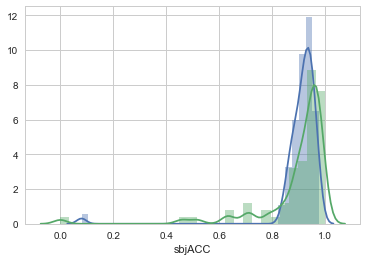

In [6]:
sns.distplot(df.loc[df.bkType=="cued"].groupby(['sbjId']).sbjACC.mean())
sns.distplot(df.loc[df.bkType=="choice"].groupby(['sbjId']).sbjACC.mean())

#### 1a. Exclude subjects with low task-switching accuracy (<75%) during cued phase and low accuracy during voluntary phase

In [9]:
#%% do a fist pass to exclude subjects with low cued task accuracy
goodSbj=[]
excludeSbj=[]
for S in np.unique(df.sbjId):
    D = df.loc[df.sbjId==S] 
    if (D[D.bkType=='cued'].sbjACC.mean()*100 >= 80) & (D[D.bkType=='choice'].sbjACC.mean()*100>= 55):
        goodSbj.append(S)
    else:
        excludeSbj.append(S)
df_valid = pd.DataFrame(np.empty((0,0),dtype=int))
for S in goodSbj:
    df_valid = pd.concat([df_valid, df[df.sbjId==S]],axis=0)
df_valid.reset_index(inplace=True)
validSCNT = len(df_valid.sbjId.unique())
print('After excluding subjects with poor performance: A total of ' + str(validSCNT) + ' subjects')

After excluding subjects with poor performance: A total of 69 subjects


### 2. Look at "Cued" Task-switching data:

Overall accuracy for the cued task-switching control task was 92.01%
Overall RT (correct trials) for the cued task-switching control task was 806.86ms


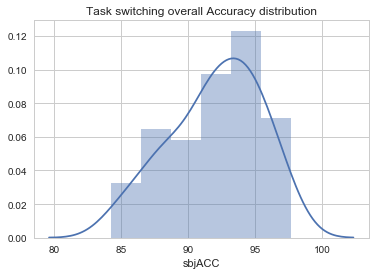

In [10]:
df_tskSw = df_valid.loc[df_valid.bkType=='cued',:].reset_index() 
sbj_tsACC = df_tskSw.groupby('sbjId').sbjACC.mean().reset_index()
# a dataframe of subject x mean_sbjACC
sns.distplot(sbj_tsACC.sbjACC*100)
plt.title('Task switching overall Accuracy distribution')
CTS_meanACC = df_tskSw.groupby('sbjId').sbjACC.mean().mean()*100
CTS_meanRT  = df_tskSw.loc[df_tskSw.sbjACC==1,:].groupby('sbjId').sbjRT.mean().mean()
print('Overall accuracy for the cued task-switching control task was ' + '{:.2f}'.format(CTS_meanACC) + '%')
print('Overall RT (correct trials) for the cued task-switching control task was ' + '{:.2f}'.format(CTS_meanRT) + 'ms')

#### 2a. Cued Task-switching ACC as a function of 2 (swProb: 25%,75%) x 2 (Trial Type: switch/repeat)

------Group mean ACC--------
swProb  trialType
sw25%   repeat       93.813741
        switch       88.982823
sw75%   repeat       93.585615
        switch       90.682591
Name: sbjACC, dtype: float64


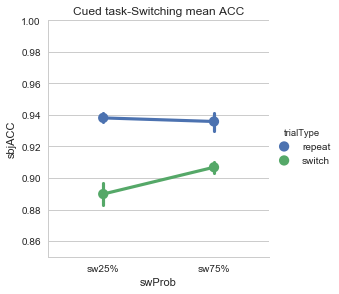

In [15]:
condM_ts_acc = df_tskSw.groupby(['sbjId','swProb','trialType']).sbjACC.mean().reset_index()  
# a dataframe of subject x condition 
gpResult_ts_acc  = condM_ts_acc.groupby(['swProb','trialType']).sbjACC.mean()*100
print('------Group mean ACC--------')
print(gpResult_ts_acc)
g= sns.factorplot(x='swProb',y='sbjACC', hue='trialType', data=df_tskSw)
g.set(ylim=(.85, 1))
plt.title("Cued task-Switching mean ACC")

#### 2b. Cued task-switching RT (correct trials) as a function of 2 (swProb: 25%,75%) x 2 (Trial Type: switch/repeat)

------Group mean RT (correct trials)--------
swProb  trialType
sw25%   repeat       752.614512
        switch       864.200677
sw75%   repeat       763.619326
        switch       859.878417
Name: sbjRT, dtype: float64


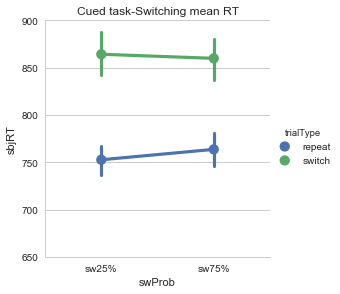

In [16]:
condM_ts_rt = df_tskSw.loc[df_tskSw.sbjACC==1,:].groupby(['sbjId','swProb','trialType']).sbjRT.mean().reset_index()  
# a dataframe of subject x condition 
gpResult_ts_rt  = condM_ts_rt.groupby(['swProb','trialType']).sbjRT.mean()
print('------Group mean RT (correct trials)--------')
print(gpResult_ts_rt)
g = sns.factorplot(x='swProb',y='sbjRT', data=condM_ts_rt , hue='trialType')
g.set(ylim=(650, 900))
plt.title("Cued task-Switching mean RT")

meanISSP = 15.33 ms
0.000601503075698


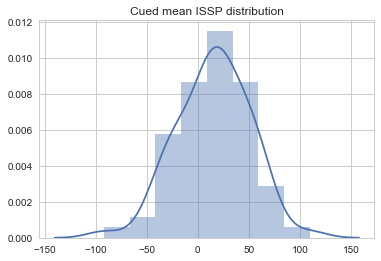

In [17]:
rt1 = np.array(condM_ts_rt.loc[(condM_ts_rt.swProb=='sw25%') & (condM_ts_rt.trialType=='switch'),'sbjRT'])
rt2 = np.array(condM_ts_rt.loc[(condM_ts_rt.swProb=='sw25%') & (condM_ts_rt.trialType=='repeat'),'sbjRT'])
rt3 = np.array(condM_ts_rt.loc[(condM_ts_rt.swProb=='sw75%') & (condM_ts_rt.trialType=='switch'),'sbjRT'])
rt4 = np.array(condM_ts_rt.loc[(condM_ts_rt.swProb=='sw75%') & (condM_ts_rt.trialType=='repeat'),'sbjRT'])
ISSP = rt1-rt2-(rt3-rt4)
print('meanISSP = ' + '{:.2f}'.format(ISSP.mean()) + ' ms')
sns.distplot(ISSP)
plt.title("Cued mean ISSP distribution")
simple_inX_test = stats.ttest_rel(rt1-rt2,rt3-rt4)
print(simple_inX_test.pvalue)

### 3. Look at "Uncued" Task-switching data:

### 3a. some preliminary look of the VTS data and drop some subjects

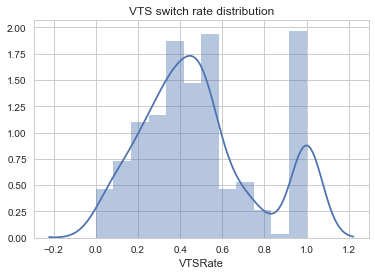

In [26]:
df_vts = df_valid.loc[(df_valid.bkType=='choice'),:].reset_index()  # after subsetting.. reset_index()
condM_vts_rate = df_vts.groupby(['sbjId','swProb','task']).trialType2.mean().reset_index()
condM_vts_rate.rename(columns={"trialType2": "VTSRate"}, inplace=True)
condM_vts_rate
g = sns.distplot(condM_vts_rate.VTSRate)
plt.title("VTS switch rate distribution")
# As there are zome 'zero' switch rates... need to exclude those subjects..

In [32]:
excludeSlist = condM_vts_rate.loc[condM_vts_rate.VTSRate<0.25,'sbjId'].unique()
print(excludeSlist)
print('drop ' + str(len(excludeSlist))+ ' subjects due to lacking >0.25 Voluntary switching rate for 1 or more conditions')
df_vts_valid = copy(df_vts)  # keep df_vts with all subjects
for S in excludeSlist: 
    df_vts_valid.drop(df_vts_valid [df_vts_valid.sbjId==S].index, axis=0, inplace=True)
print('Nr of valid subjects: ' + str(len(df_vts_valid.sbjId.unique())))
len(df_vts_valid.sbjId.unique())

[  2.   3.   5.   6.   9.  10.  14.  15.  16.  17.  19.  20.  23.  24.  25.
  29.  32.  34.  37.  40.  44.  47.  50.  53.  60.  61.  62.  63.  65.]
drop 29 subjects due to lacking >0.25 Voluntary switching rate for 1 or more conditions
Nr of valid subjects: 40


40

### 3b. volutary task-switching rate as a function of swProb (25% vs. 75%) x task (Parity vs. Magnitude)

------Group VTS rate (all trials)--------
task     swProb
animacy  sw25%     45.986094
         sw75%     46.062066
size     sw25%     49.362017
         sw75%     48.630211
Name: trialType2, dtype: float64
-----------------------------------------
mean vts_rate = 47.51 %


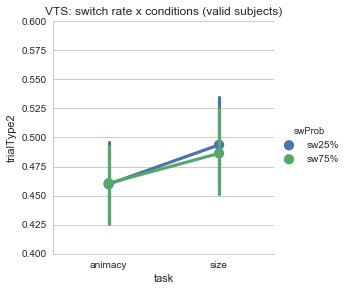

In [46]:
condM_vts_rate_valid = df_vts_valid[df_vts_valid.task!=-1].groupby(['sbjId','swProb','task']).trialType2.mean().reset_index()
# a dataframe of subject x condition 
gpResult_vts_rate_valid  = condM_vts_rate_valid.groupby(['task','swProb']).trialType2.mean()*100
print('------Group VTS rate (all trials)--------')
print(gpResult_vts_rate_valid)
print('-----------------------------------------')
print('mean vts_rate = ' + '{:.2f}'.format(condM_vts_rate_valid.trialType2.mean()*100) + ' %')

g= sns.factorplot(x='task',y='trialType2', hue='swProb', data=condM_vts_rate_valid)   # trialType2 is sw(1) or repeat(0)
g.set(ylim=(0.4, 0.6))
plt.title("VTS: switch rate x conditions (valid subjects)")

### 3c. VTS rate: testing interaction between 2 swProb (25% vs. 75%) x 2 task (Parity vs. Magnitude) 

In [49]:
rate1 = np.array(condM_vts_rate_valid.loc[(condM_vts_rate_valid.swProb=='sw25%') & (condM_vts_rate_valid.task=='animacy'),'trialType2'])
rate2 = np.array(condM_vts_rate_valid.loc[(condM_vts_rate_valid.swProb=='sw25%') & (condM_vts_rate_valid.task=='size'),'trialType2'])
rate3 = np.array(condM_vts_rate_valid.loc[(condM_vts_rate_valid.swProb=='sw75%') & (condM_vts_rate_valid.task=='animacy'),'trialType2'])
rate4 = np.array(condM_vts_rate_valid.loc[(condM_vts_rate_valid.swProb=='sw75%') & (condM_vts_rate_valid.task=='size'),'trialType2'])
vts_rate_inX = (rate1-rate2-(rate3-rate4))*100
simple_inX_test = stats.ttest_rel(rate1-rate2,rate3-rate4)
print('2 swProb x 2 task VTS_rate interaction p value: ' + '{:.2f}'.format(simple_inX_test.pvalue))
paired_ttest = stats.ttest_rel(rate2,rate4)
print('Magnitude task: 75% vs. 25% p: ' + '{:.2f}'.format(paired_ttest.pvalue))

2 swProb x 2 task VTS_rate interaction p value: 0.72
Magnitude task: 75% vs. 25% p: 0.69


### 3d. volutary task-switching ACC as a function of swProb (25% vs. 75%) x trial Type (Switch vs. Repeat)

------VTS: Group mean ACC--------
swProb  trialType
sw25%   repeat       0.932372
        switch       0.900632
sw75%   repeat       0.940054
        switch       0.901388
Name: sbjACC, dtype: float64


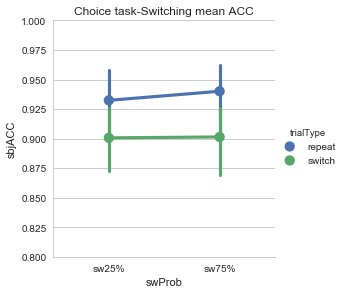

In [53]:
condM_vts_valid_acc = df_vts_valid.groupby(['sbjId','swProb','trialType']).sbjACC.mean().reset_index()  
# a dataframe of subject x condition 
gpResult_vts_valid_acc  = condM_vts_valid_acc.groupby(['swProb','trialType']).sbjACC.mean()
print('------VTS: Group mean ACC--------')
print(gpResult_vts_valid_acc )
g=sns.factorplot(x='swProb',y='sbjACC', hue='trialType',data=condM_vts_valid_acc) ### always plot the dataframe with subject-based condition means, Don't plot the orig dataframe
g.set(ylim=(0.8, 1))
plt.title("Choice task-Switching mean ACC")

### 3d. volutary task-switching RT (correct trials) as a function of swProb (25% vs. 75%) x trial Type (Switch vs. Repeat)

------VTS: Group mean RT (correct trials)--------
swProb  trialType
sw25%   repeat       723.055503
        switch       770.065101
sw75%   repeat       739.346130
        switch       780.787649
Name: sbjRT, dtype: float64


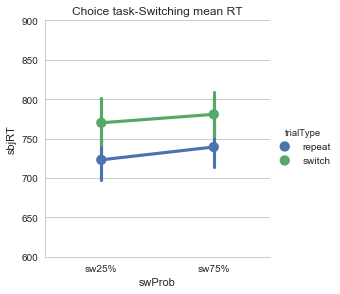

In [55]:
condM_vts_valid_rt = df_vts_valid.loc[df_vts_valid.sbjACC==1].groupby(['sbjId','swProb','trialType']).sbjRT.mean().reset_index()  
gpResult_vts_valid_rt  = condM_vts_valid_rt.groupby(['swProb','trialType']).sbjRT.mean()
print('------VTS: Group mean RT (correct trials)--------')
print(gpResult_vts_valid_rt )
g = sns.factorplot(x='swProb',y='sbjRT', hue='trialType',data = condM_vts_valid_rt)
plt.title("Choice task-Switching mean RT")
g.set(ylim=(600, 900))

meanISSP = 5.57 ms
0.588864979501


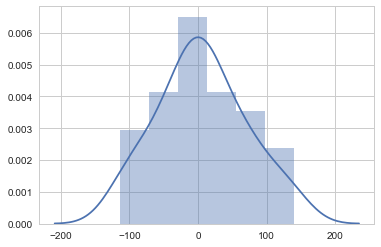

In [56]:
rt1 = np.array(condM_vts_valid_rt.loc[(condM_vts_valid_rt.swProb=='sw25%') & (condM_vts_valid_rt.trialType=='switch'),'sbjRT'])
rt2 = np.array(condM_vts_valid_rt.loc[(condM_vts_valid_rt.swProb=='sw25%') & (condM_vts_valid_rt.trialType=='repeat'),'sbjRT'])
rt3 = np.array(condM_vts_valid_rt.loc[(condM_vts_valid_rt.swProb=='sw75%') & (condM_vts_valid_rt.trialType=='switch'),'sbjRT'])
rt4 = np.array(condM_vts_valid_rt.loc[(condM_vts_valid_rt.swProb=='sw75%') & (condM_vts_valid_rt.trialType=='repeat'),'sbjRT'])
vts_ISSP = rt1-rt2-(rt3-rt4)
print('meanISSP = ' + '{:.2f}'.format(vts_ISSP.mean()) + ' ms')
sns.distplot(vts_ISSP)
simple_inX_test = stats.ttest_rel(rt1-rt2,rt3-rt4)
print(simple_inX_test.pvalue)